In [44]:
import pandas as pd
import datetime as dt
import numpy as np

In [45]:
import matplotlib.pyplot as plt

In [46]:
# chainerと必要なパッケージをインポート
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions
import chainer.cuda

In [47]:
# ニューラルネットワークモデルを作成
class RNN(Chain):
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units)
            self.l2 = L.Linear(None, n_output)
        
    def reset_state(self):
        self.l1.reset_state()
 
        
    def __call__(self, x, t):
        y = self.predict(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss},self)
        return loss
        
    def predict(self, x):
        if train:
            h1 = F.dropout(self.l1(x),ratio = 0.5)
        else:
            h1 = self.l1(x)
        return self.l2(h1)

In [48]:
## LSTMUpdaterを作る。
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater,self).__init__(data_iter, optimizer, device=None)
        self.device = device
        
    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")
        
        batch = data_iter.__next__()
        x_batch, t_batch = chainer.dataset.concat_examples(batch, self.device)
        
        optimizer.target.reset_state()           
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, t_batch)
        loss.backward()
        loss.unchain_backward()                  
        optimizer.update() 

In [49]:
# ファイルを読み込む
air = pd.read_csv('AirPassengers.csv')

In [50]:
air.shape

(144, 1)

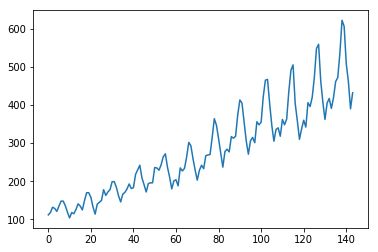

In [51]:
plt.plot(air)
plt.show()

In [52]:
#標準化
from sklearn.preprocessing import MinMaxScaler

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [54]:
air = scaler.fit_transform(air)

In [55]:
df = air

In [56]:
#訓練データと教師データへの分割
 
x,t = [],[]
 
N = len(df)
M = 12
for n in range(M,N):
  _x = df[n-M:n]
  _t = df[n]
  x.append(_x)
  t.append(_t)
 

In [57]:

x = np.array(x, dtype = np.float32)
t = np.array(t, dtype = np.float32).reshape(len(t),1)
 
# 訓練：80%, 検証：20%で分割する
n_train = int(len(x) * 0.8)
dataset = list(zip(x, t))
train, test = chainer.datasets.split_dataset(dataset, n_train)

In [58]:
# 乱数のシードを固定 (再現性の確保)
np.random.seed(1)
 
# モデルの宣言
model = RNN(30, 1)
 
# GPU対応
#chainer.cuda.get_device(0).use()
#model.to_gpu()                 
 
# Optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)
 
# Iterator
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
 
# Updater &lt;- LSTM用にカスタマイズ
updater = LSTMUpdater(train_iter, optimizer,device = -1)
 
# Trainerとそのextensions
epoch = 3000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
 
# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model,device = -1))
 
# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
 
# １エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']),
               trigger=(1, 'epoch'))


In [59]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           0.13323     0.466175              0.0315982     
2           0.131654    0.34158               0.0606721     
3           0.0867893   0.243043              0.0967091     
4           0.078605    0.169243              0.130359      
5           0.059979    0.0928551             0.158816      
6           0.0414204   0.0538777             0.185419      
7           0.0357814   0.0365943             0.209664      
8           0.0288119   0.0249858             0.23391       
9           0.0248045   0.0282096             0.271242      
10          0.021293    0.0375424             0.304186      
11          0.0250693   0.0523242             0.331767      
12          0.0204217   0.0576935             0.356085      
13          0.0167981   0.052318              0.384231      
14          0.021886    0.0612986             0.410128      
15          0.0208302   0.054821              0.435672      
16          0.0214428   0.

140         0.00604471  0.024569              4.87954       
141         0.00373205  0.0159832             4.92048       
142         0.00554306  0.01969               4.96267       
143         0.00410565  0.0143505             4.99894       
144         0.00461806  0.0133721             5.03358       
145         0.00475517  0.0129267             5.07291       
146         0.00575672  0.0180203             5.1177        
147         0.00460362  0.0263833             5.16085       
148         0.006029    0.0212211             5.19921       
149         0.00639997  0.0148319             5.24109       
150         0.00482954  0.0131849             5.27613       
151         0.00646794  0.0149882             5.31925       
152         0.00504573  0.0147872             5.35994       
153         0.00529395  0.0174279             5.40137       
154         0.00407508  0.0181448             5.43774       
155         0.00554645  0.0200679             5.47366       
156         0.00493506  

275         0.00329851  0.0127983             10.7907       
276         0.00403222  0.0144785             10.8366       
277         0.00317299  0.0104742             10.8828       
278         0.002949    0.0102824             10.9277       
279         0.00306826  0.0112229             10.9693       
280         0.00374446  0.0152229             11.0109       
281         0.00424935  0.0161988             11.0583       
282         0.00385187  0.0149118             11.1102       
283         0.00391854  0.0133305             11.1514       
284         0.00364781  0.0120186             11.1947       
285         0.00315699  0.0098527             11.247        
286         0.00492689  0.00866663            11.2962       
287         0.00321769  0.0110707             11.3374       
288         0.00342375  0.0140837             11.3951       
289         0.00382171  0.0111196             11.4428       
290         0.00348914  0.00610199            11.4924       
291         0.00396347  

411         0.00251792  0.010288              17.9047       
412         0.00251824  0.00831727            17.9691       
413         0.00290057  0.0156469             18.0209       
414         0.00233203  0.0110551             18.0752       
415         0.00195212  0.00896769            18.1518       
416         0.00223048  0.00709753            18.2311       
417         0.00365255  0.00977281            18.3092       
418         0.00302789  0.0112114             18.3754       
419         0.00308504  0.00653503            18.4458       
420         0.00277871  0.00982889            18.5039       
421         0.00323361  0.00964146            18.5574       
422         0.00254109  0.0148005             18.6021       
423         0.00229511  0.00897671            18.6508       
424         0.00263292  0.00954403            18.7182       
425         0.00330111  0.00745123            18.7977       
426         0.00217202  0.0121731             18.8682       
427         0.00375049  

548         0.00278415  0.00891556            25.3093       
549         0.00275109  0.00987938            25.3737       
550         0.00213924  0.00910039            25.4261       
551         0.0023888   0.0100865             25.4788       
552         0.0016726   0.0144315             25.5395       
553         0.00262732  0.00890001            25.6117       
554         0.0028531   0.0101398             25.667        
555         0.00175848  0.00932503            25.7198       
556         0.00261803  0.0145673             25.7711       
557         0.00309497  0.0101154             25.8416       
558         0.00257495  0.00892893            25.8948       
559         0.00227878  0.00744249            25.9416       
560         0.00285194  0.00768743            25.9898       
561         0.00237069  0.0079611             26.0513       
562         0.00274554  0.00977809            26.0985       
563         0.00195536  0.0104023             26.1533       
564         0.00219991  

685         0.00238274  0.0122469             33.1948       
686         0.00214593  0.00790594            33.2595       
687         0.00206867  0.0122862             33.3124       
688         0.00154828  0.0126708             33.4027       
689         0.00190192  0.00915549            33.4605       
690         0.00246351  0.00890468            33.519        
691         0.00216773  0.00679398            33.5816       
692         0.00179245  0.00661167            33.636        
693         0.0019121   0.00627719            33.6938       
694         0.00226891  0.00811443            33.7579       
695         0.00202994  0.00668839            33.8157       
696         0.00213233  0.0132289             33.8673       
697         0.00190166  0.0126502             33.9279       
698         0.00162844  0.0091101             33.9873       
699         0.00226858  0.00918642            34.0393       
700         0.00203745  0.0083048             34.1056       
701         0.00234891  

823         0.00192453  0.0149055             42.0731       
824         0.00199546  0.0124528             42.1419       
825         0.00205488  0.00823704            42.2026       
826         0.00187334  0.0122864             42.277        
827         0.00168286  0.0145673             42.3343       
828         0.00175955  0.0113152             42.401        
829         0.00159706  0.00976647            42.4612       
830         0.00190573  0.0132687             42.5272       
831         0.00198187  0.0112379             42.5895       
832         0.00169624  0.0112227             42.656        
833         0.00197504  0.0129179             42.7231       
834         0.00226632  0.0112058             42.7869       
835         0.0016039   0.0150055             42.8472       
836         0.00216796  0.00861747            42.9137       
837         0.00205926  0.00963032            42.9737       
838         0.00199485  0.0112109             43.031        
839         0.00160089  

959         0.00192232  0.00674434            51.4214       
960         0.00194701  0.0130579             51.4855       
961         0.00246351  0.0104577             51.547        
962         0.0018751   0.00685982            51.614        
963         0.00164544  0.00849535            51.6805       
964         0.0020698   0.0131876             51.7453       
965         0.00201198  0.00919676            51.8097       
966         0.00182067  0.0104721             51.8743       
967         0.00177502  0.0142266             51.9363       
968         0.00192236  0.00874116            52.0099       
969         0.00171075  0.00701888            52.0755       
970         0.00176086  0.00538062            52.1366       
971         0.00227747  0.0095172             52.2033       
972         0.00141753  0.0101489             52.2729       
973         0.00232914  0.00741017            52.3396       
974         0.00180795  0.0109954             52.4052       
975         0.00201579  

1094        0.00128341  0.0125276             61.0362       
1095        0.0019382   0.0103624             61.1037       
1096        0.00149943  0.0163324             61.1745       
1097        0.00198849  0.00746487            61.2498       
1098        0.0021184   0.00852812            61.3244       
1099        0.00148369  0.010971              61.3914       
1100        0.00218882  0.0100367             61.467        
1101        0.00158482  0.0101639             61.5537       
1102        0.00191438  0.0102695             61.6604       
1103        0.00197087  0.00741253            61.7262       
1104        0.00189589  0.0155628             61.7952       
1105        0.00135984  0.0106266             61.8664       
1106        0.00130546  0.00970958            61.9454       
1107        0.00157848  0.0100062             62.021        
1108        0.00181251  0.0143184             62.0951       
1109        0.00160292  0.0101318             62.1584       
1110        0.00231259  

1230        0.00215352  0.011122              71.067        
1231        0.0017788   0.00896686            71.1499       
1232        0.00147663  0.00837384            71.2191       
1233        0.00151112  0.00993405            71.2961       
1234        0.00161893  0.0110455             71.3732       
1235        0.00175239  0.0101771             71.4386       
1236        0.0016882   0.0136923             71.5103       
1237        0.00204445  0.00949475            71.597        
1238        0.0019209   0.00946074            71.6644       
1239        0.00159729  0.00953142            71.7419       
1240        0.00189135  0.0145454             71.8254       
1241        0.00161414  0.00831649            71.8947       
1242        0.00171392  0.0122104             71.9847       
1243        0.00251097  0.00585591            72.0657       
1244        0.00172891  0.00753653            72.1387       
1245        0.00176462  0.00762222            72.2112       
1246        0.00169199  

1366        0.00183155  0.00951165            81.7548       
1367        0.00144213  0.00627182            81.8374       
1368        0.00178082  0.00801595            81.9172       
1369        0.00186869  0.00965035            81.996        
1370        0.00159381  0.0144944             82.0812       
1371        0.00159657  0.0126864             82.155        
1372        0.00161586  0.00784466            82.2283       
1373        0.00167278  0.0109001             82.3124       
1374        0.00183476  0.0105224             82.391        
1375        0.00140268  0.00968308            82.4644       
1376        0.00142317  0.00731684            82.5445       
1377        0.00144943  0.0111979             82.6237       
1378        0.00192704  0.0165651             82.6936       
1379        0.00206704  0.0144367             82.7719       
1380        0.00152866  0.0110541             82.8481       
1381        0.00190644  0.00878242            82.9262       
1382        0.00142991  

1502        0.00142335  0.0110791             92.8867       
1503        0.00172043  0.00862555            92.9776       
1504        0.00196894  0.0124894             93.0777       
1505        0.00140017  0.0088424             93.1626       
1506        0.00135157  0.0104751             93.2543       
1507        0.00172414  0.010578              93.3306       
1508        0.00149685  0.010926              93.4263       
1509        0.00158162  0.0159507             93.5137       
1510        0.00193983  0.0136184             93.5898       
1511        0.00159125  0.00773798            93.6716       
1512        0.00158078  0.0113159             93.7598       
1513        0.00187224  0.0121721             93.8427       
1514        0.00165739  0.013991              93.9229       
1515        0.00150859  0.00858737            94.0265       
1516        0.00154926  0.00762104            94.1069       
1517        0.00205444  0.00910912            94.1895       
1518        0.00162277  

1638        0.00134173  0.0138377             104.666       
1639        0.0020916   0.00997126            104.76        
1640        0.00162104  0.00901639            104.844       
1641        0.00129993  0.00954002            104.942       
1642        0.00155261  0.0110364             105.046       
1643        0.00169856  0.00615301            105.13        
1644        0.00165642  0.011672              105.209       
1645        0.00129759  0.0166937             105.303       
1646        0.0018319   0.0139564             105.414       
1647        0.000956433  0.0100976             105.493       
1648        0.00162478  0.0117145             105.583       
1649        0.00135529  0.0164843             105.668       
1650        0.00204221  0.0128253             105.761       
1651        0.00149869  0.00932833            105.85        
1652        0.00124194  0.014891              105.931       
1653        0.00229618  0.0153181             106.017       
1654        0.00222042 

1775        0.00199877  0.0111692             117.024       
1776        0.0016277   0.0107871             117.118       
1777        0.00231189  0.0141774             117.211       
1778        0.00145315  0.00699595            117.3         
1779        0.0016947   0.0138299             117.392       
1780        0.00144267  0.0111954             117.48        
1781        0.00100159  0.011936              117.572       
1782        0.00181087  0.00698405            117.68        
1783        0.00157529  0.0112525             117.764       
1784        0.0012369   0.00846537            117.853       
1785        0.00132752  0.0102718             117.954       
1786        0.00230675  0.0103078             118.042       
1787        0.00146079  0.0105583             118.13        
1788        0.0015587   0.0138617             118.237       
1789        0.00186637  0.0113407             118.326       
1790        0.00151637  0.0130423             118.407       
1791        0.001649    

1910        0.00192276  0.00754043            129.949       
1911        0.00161901  0.0086696             130.086       
1912        0.00180288  0.00866394            130.173       
1913        0.00131856  0.0122409             130.262       
1914        0.00153796  0.00950468            130.36        
1915        0.00202495  0.0126941             130.456       
1916        0.00155441  0.0109658             130.542       
1917        0.001327    0.0111256             130.638       
1918        0.00207067  0.01091               130.726       
1919        0.00158103  0.00664097            130.818       
1920        0.0012942   0.00947553            130.912       
1921        0.00227775  0.0108449             131.003       
1922        0.00194618  0.0168271             131.095       
1923        0.00147188  0.00927505            131.194       
1924        0.00115687  0.0109187             131.286       
1925        0.00131433  0.00931753            131.417       
1926        0.0012303   

2046        0.00137001  0.00737721            143.453       
2047        0.00208471  0.0106779             143.562       
2048        0.00197021  0.0127093             143.667       
2049        0.00144238  0.0114081             143.781       
2050        0.00143423  0.0130856             143.886       
2051        0.0016552   0.0103632             143.983       
2052        0.00105948  0.0118684             144.073       
2053        0.00157782  0.0095356             144.294       
2054        0.00121309  0.0103875             144.409       
2055        0.00137212  0.00990204            144.502       
2056        0.00136735  0.0116166             144.597       
2057        0.00191442  0.0126147             144.744       
2058        0.00172436  0.00678854            144.858       
2059        0.00138226  0.0146629             144.96        
2060        0.00162067  0.0159866             145.058       
2061        0.00155115  0.0136168             145.156       
2062        0.00210899  

2181        0.00135806  0.00912466            157.775       
2182        0.00147076  0.0184857             157.876       
2183        0.00218348  0.0102322             157.982       
2184        0.00172858  0.0150433             158.079       
2185        0.00155827  0.00996578            158.213       
2186        0.0015645   0.00985999            158.318       
2187        0.00159088  0.0108133             158.421       
2188        0.0012591   0.0111674             158.514       
2189        0.00116871  0.00960701            158.631       
2190        0.00158681  0.0155218             158.744       
2191        0.00199761  0.0103031             158.852       
2192        0.0011593   0.00832159            158.953       
2193        0.00130948  0.0124969             159.049       
2194        0.00151911  0.0111296             159.146       
2195        0.00141973  0.0193696             159.265       
2196        0.00102803  0.0120423             159.414       
2197        0.00186352  

2317        0.00130442  0.0126527             174.402       
2318        0.00162026  0.0117953             174.517       
2319        0.00196269  0.0127108             174.625       
2320        0.00177319  0.00800471            174.729       
2321        0.00196497  0.00790515            174.889       
2322        0.00110941  0.0114146             174.989       
2323        0.00210339  0.0146704             175.086       
2324        0.00153516  0.0161735             175.184       
2325        0.00119842  0.0118731             175.292       
2326        0.00158116  0.0105809             175.405       
2327        0.00152654  0.00911269            175.524       
2328        0.00125952  0.0120166             175.667       
2329        0.00157924  0.0110163             175.772       
2330        0.00167516  0.008422              175.878       
2331        0.00167093  0.01642               175.986       
2332        0.00153864  0.00930192            176.11        
2333        0.00202032  

2452        0.00138677  0.00998078            190.658       
2453        0.00179138  0.0128872             190.794       
2454        0.0016534   0.0154421             190.921       
2455        0.00145073  0.0101779             191.067       
2456        0.00165635  0.0133742             191.174       
2457        0.00149082  0.0114927             191.298       
2458        0.0011499   0.00641461            191.424       
2459        0.00128201  0.0207734             191.568       
2460        0.00180676  0.0089316             191.748       
2461        0.00141136  0.0107373             191.915       
2462        0.00161411  0.0115291             192.049       
2463        0.00147118  0.0111458             192.159       
2464        0.00170571  0.0133381             192.288       
2465        0.0013011   0.0156271             192.401       
2466        0.00233422  0.00913964            192.522       
2467        0.00150823  0.00936071            192.633       
2468        0.00116317  

2587        0.00234916  0.008901              208.342       
2588        0.00183169  0.0110557             208.536       
2589        0.00225978  0.011918              208.759       
2590        0.00100649  0.0109274             208.883       
2591        0.00121786  0.00907188            208.999       
2592        0.00189114  0.0171127             209.101       
2593        0.00130593  0.00920878            209.212       
2594        0.00117286  0.0165829             209.314       
2595        0.00139107  0.0135277             209.419       
2596        0.00160459  0.00986012            209.519       
2597        0.00195905  0.0112288             209.633       
2598        0.0018517   0.0105471             209.735       
2599        0.0019294   0.0105094             209.836       
2600        0.00165684  0.00797034            209.938       
2601        0.00130231  0.0108889             210.05        
2602        0.00157761  0.0147138             210.291       
2603        0.00145569  

2722        0.00165653  0.0144448             231.722       
2723        0.00153121  0.0119476             231.937       
2724        0.00140976  0.0152117             232.149       
2725        0.00132127  0.0143357             232.366       
2726        0.00168743  0.00862032            232.687       
2727        0.00140321  0.0122389             232.949       
2728        0.00146147  0.0158695             233.188       
2729        0.00151113  0.0133254             233.431       
2730        0.00143846  0.00738943            233.615       
2731        0.001762    0.0113947             233.813       
2732        0.00153166  0.015684              233.964       
2733        0.00117476  0.0107262             234.161       
2734        0.00221122  0.00981766            234.348       
2735        0.0015776   0.0154636             234.562       
2736        0.00178073  0.0130306             234.71        
2737        0.00158789  0.0127455             234.884       
2738        0.00132065  

2857        0.00135338  0.0150553             252.529       
2858        0.00161573  0.00797306            252.643       
2859        0.00186515  0.011874              252.759       
2860        0.00138574  0.0130707             252.932       
2861        0.00181948  0.00990965            253.079       
2862        0.00192365  0.0127764             253.195       
2863        0.00142576  0.0187993             253.31        
2864        0.00133538  0.0111031             253.422       
2865        0.00158089  0.0136071             253.578       
2866        0.00135938  0.0125769             253.734       
2867        0.00195173  0.010517              253.853       
2868        0.00165196  0.0103584             253.968       
2869        0.00134551  0.0114886             254.102       
2870        0.00173132  0.0127454             254.252       
2871        0.00115457  0.00997935            254.369       
2872        0.00140242  0.00885557            254.499       
2873        0.00109405  

2993        0.00145548  0.00863512            270.205       
2994        0.00120966  0.0134688             270.326       
2995        0.0017332   0.01346               270.445       
2996        0.00189915  0.0108234             270.561       
2997        0.00144116  0.0126643             270.679       
2998        0.00140017  0.00910822            270.8         
2999        0.00162645  0.0085316             270.915       
3000        0.00132187  0.010613              271.035       


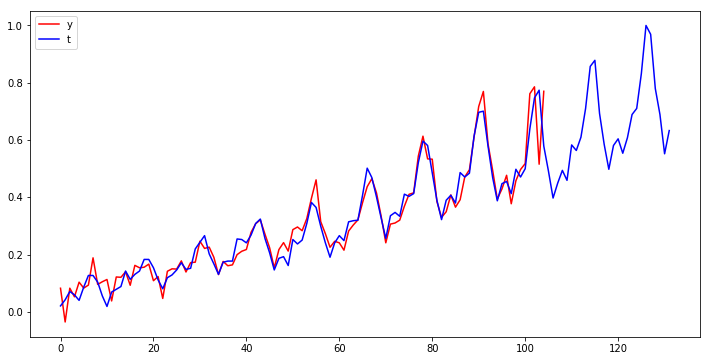

In [60]:
# 訓練：80%, 検証：20%で分割する
n_train = int(len(x) * 0.8)
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]
 
# 訓練データ
model.reset_state()
train_y = model.predict(Variable(train_x)).data
n_train = int(len(x) * 1)
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:].data
 
# プロット
plt.figure(figsize=(12,6))
 
 
plt.plot(train_y, color='red',label="y")   # 予測値
plt.plot(train_t, color='blue',label="t")  # 実測値
plt.legend(loc="upper left")
plt.show()

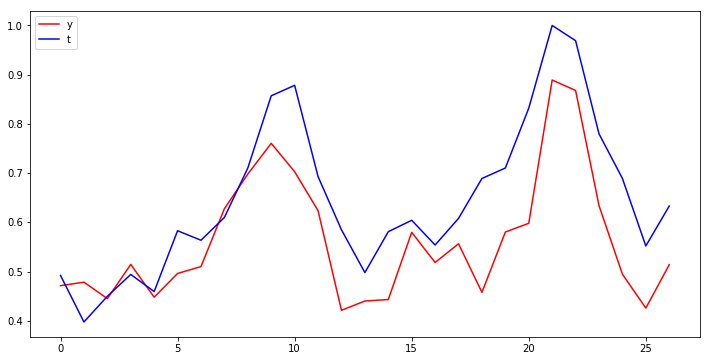

In [61]:
# 訓練：80%, 検証：20%で分割する
n_train = int(len(x) * 0.8)
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]
 

# 検証データ
model.reset_state()
test_y = model.predict(Variable(test_x)).data
 
# プロット
plt.figure(figsize=(12,6))
 
plt.plot(test_y, color='red',label="y")   # 予測値
plt.plot(test_t, color='blue',label="t")  # 実測値
plt.legend(loc="upper left")
plt.show()